# Epileptic Seizure Recognition

Информация об атрибутах:

Исходный набор данных из справочника состоит из 5 разных папок, каждая из которых содержит 100 файлов, каждый из которых представляет один субъект/человека. Каждый файл представляет собой запись активности мозга в течение 23,6 секунд. Соответствующий временной ряд разбивается на 4097 точек данных. Каждая точка данных представляет собой значение записи ЭЭГ в другой момент времени. Итак, у нас всего 500 человек, у каждого из которых 4097 точек данных за 23,5 секунды.

Мы разделили и перетасовали каждые 4097 точек данных на 23 части, каждая часть содержит 178 точек данных за 1 секунду, и каждая точка данных представляет собой значение записи ЭЭГ в другой момент времени. Итак, теперь у нас есть 23 x 500 = 11500 единиц информации (строка), каждая информация содержит 178 точек данных за 1 секунду (столбец), последний столбец представляет собой метку y {1,2,3,4,5}.

Переменная отклика — y в столбце 179, объясняющие переменные X1, X2, …, X178.

y содержит категорию 178-мерного входного вектора. В частности, y в {1, 2, 3, 4, 5}:

5 - глаза открыты, значит при записи ЭЭГ-сигнала головного мозга у больного были открыты глаза

4 - глаза закрыты, значит, при записи сигнала ЭЭГ у пациента были закрыты глаза

3 - Да, они определяют, где в мозгу находилась область опухоли, и регистрируют активность ЭЭГ в здоровой области мозга.

2 - Регистрируют ЭЭГ из области локализации опухоли.

1 - Запись судорожной активности

Все субъекты, относящиеся к классам 2, 3, 4 и 5, не имели эпилептического припадка. Эпилептические припадки наблюдаются только у субъектов из класса 1. Нашей мотивацией для создания этой версии данных было упростить доступ к данным путем создания их версии .csv. Хотя существует 5 классов, большинство авторов провели бинарную классификацию, а именно класс 1 (эпилептический припадок) по сравнению с остальными.


In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.8 MB/s eta 0:00:00


In [2]:
!pip install tsfel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from catboost import CatBoostClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.fftpack import fft
from scipy import signal
from tqdm import tqdm
import pywt
import scipy.stats
from collections import defaultdict, Counter
import tsfel
from scipy import interpolate
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

## Загрузка данных

In [4]:
url= 'https://drive.google.com/uc?id=' + "https://drive.google.com/file/d/1w1UJUAy1pekERaIUaluksqRlUhefG-Cd/view?usp=sharing".split('/')[-2]
df = pd.read_csv(url)

In [5]:
df.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [6]:
df.shape

(11500, 180)

In [7]:
df.isna().sum().sum()

0

Пропусков нет, но присутсвует неиспользуемая колнока unnamed, которую следует удалить. Все субъекты в целевой переменной, не относящиеся к припадку, преобразую в 0 и посмотрю на распределение целевой переменной.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


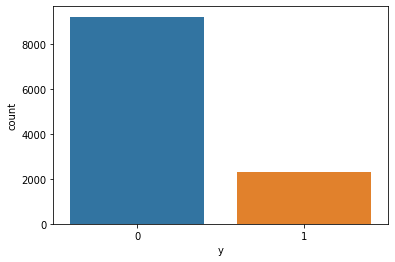

In [8]:
df = df.drop('Unnamed', axis=1)
df.loc[df['y'] != 1, 'y'] = 0
X = df.drop('y', axis=1)
y = df['y']

ax = sns.countplot(y, label="Count");

In [9]:
y.value_counts()

0    9200
1    2300
Name: y, dtype: int64

## Baseline

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12345)

In [11]:
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("Confusion Matrix:\n",confusion_matrix(y_test,pred))
print("Classification Report:\n",classification_report(y_test,pred))

Confusion Matrix:
 [[1823   17]
 [  40  420]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1840
           1       0.96      0.91      0.94       460

    accuracy                           0.98      2300
   macro avg       0.97      0.95      0.96      2300
weighted avg       0.98      0.98      0.97      2300



Неплохие результаты. Теперь попробую применить преобразование Фурье.

## Использование преобразования Фурье

In [12]:
N = 178 # длина сигнала
t_n = 1 # длина нашего сигнала в секундах
T = t_n / N # период сигнала

In [13]:
def get_fft_values(y_values, T, N):  
    # 
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

In [14]:
f_values, fft_values = get_fft_values(X.T, T, N)

In [15]:
X_f = fft_values.T
X_f.shape

(11500, 89)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.2, stratify=y, random_state=12345)

In [17]:
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("Confusion Matrix:\n",confusion_matrix(y_test,pred))
print("Classification Report:\n",classification_report(y_test,pred))

Confusion Matrix:
 [[1751   89]
 [ 442   18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87      1840
           1       0.17      0.04      0.06       460

    accuracy                           0.77      2300
   macro avg       0.48      0.50      0.47      2300
weighted avg       0.67      0.77      0.71      2300



Прогноз значительно ухудшился.

## Wavelet преобразование

In [18]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(
        np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_uci_har_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in tqdm(range(0, len(dataset)), leave=False):
        features = []
        
        signal = dataset[signal_no]
        
        list_coeff = pywt.wavedec(signal, waveletname)
        for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y

In [19]:
waveletname = 'rbio3.1'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12345)
X_train = [X_train.iloc[i] for i in range(len(X_train))]
X_test = [X_test.iloc[i] for i in range(len(X_test))]

X_train, Y_train = get_uci_har_features(X_train, y_train, waveletname)
X_test, Y_test = get_uci_har_features(X_test, y_test, waveletname)

In [20]:
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("Confusion Matrix:\n",confusion_matrix(y_test,pred))
print("Classification Report:\n",classification_report(y_test,pred))

Confusion Matrix:
 [[1826   14]
 [  14  446]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.97      0.97      0.97       460

    accuracy                           0.99      2300
   macro avg       0.98      0.98      0.98      2300
weighted avg       0.99      0.99      0.99      2300



Результат значительно улучшился по сравнению с преобразованием Фурье и показал лучшие результаты, чем в baseline.

## TSFEL

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12345)

In [22]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

In [23]:
X_train.shape, X_test.shape

((9200, 175), (2300, 175))

In [24]:
cfg_file = tsfel.get_features_by_domain('temporal')

In [25]:
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("Confusion Matrix:\n",confusion_matrix(y_test,pred))
print("Classification Report:\n",classification_report(y_test,pred))

Confusion Matrix:
 [[1825   15]
 [  40  420]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1840
           1       0.97      0.91      0.94       460

    accuracy                           0.98      2300
   macro avg       0.97      0.95      0.96      2300
weighted avg       0.98      0.98      0.98      2300



## Вывод
Результат немного улучшился по сравнению с Baseline. Но лучшие результаты показала модель с признаками, полученными после вельвет преобразования.